# Big Mart Sales Prediction

## 1. load Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import pickle

In [209]:
# ==================== General Purpose ====================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

# ==================== Visualization ====================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set consistent style and color palette
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10, 6)

# ==================== Statistical Tools ====================
from scipy.stats import zscore

# ==================== Preprocessing ====================
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# ==================== Feature Engineering ====================
from sklearn.feature_selection import mutual_info_classif

# ==================== Modeling ====================
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


# ==================== Imbalanced Data Handling ====================
from imblearn.over_sampling import SMOTE

# ==================== Hyperparameter Tuning ====================
from sklearn.model_selection import GridSearchCV
import optuna

# ==================== Evaluation ====================
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    f1_score, classification_report, confusion_matrix, make_scorer
)

# ==================== Explainability ====================
import shap

In [5]:
config = {
        "base_path": '/Users/A117870943/Documents/documents/Assignment/Analytics_vidya/data/'
         }

In [6]:
class EDAUtils:
    """
    A utility class for performing exploratory data analysis (EDA) on a pandas DataFrame.
    
    Methods include:
    - Column type detection
    - Summary statistics for numeric/categorical columns
    - Visualization utilities (e.g., bar plots, KDE, boxplots)
    - Mutual information computation
    """
    
    @staticmethod
    def load_data(config, path):
        """
        Load CSV data from the specified path.
    
        Args:
            config: Dictionary containing base_path.
            path: Relative path to the CSV file.
    
        Returns:
            Loaded DataFrame.
        """
        
        df = pd.read_csv(config['base_path'] + path)
        print("Shape of Data:", df.shape)
        return df

    @staticmethod
    def get_percentage(df, col):
        """
        Calculate the percentage of each category in the given column.
    
        Args:
            df: Input DataFrame.
            col: Column name.
    
        Returns:
            A Series with percentage distribution.
        """
        percentages = 100 * df[col].value_counts(normalize=True)
        print(percentages)

    @staticmethod
    def get_cols(df):
        """
        Identify numerical and categorical variables in the DataFrame.
    
        Args:
            df: Input DataFrame.
    
        Returns:
            lists: (numerical_columns, categorical_columns)
        """
        numeric_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_var = df.select_dtypes(include=['object']).columns.tolist()
        
        return numeric_var, cat_var
    
    # @staticmethod
    # def segregate_cols(df):
    #     """
    #     Identify numerical and categorical variables in the DataFrame.
    
    #     Args:
    #         df: Input DataFrame.
    
    #     Returns:
    #         lists: (numerical_columns, categorical_columns)
    #     """
            

    #     id_col = ['id','slot_date']
    #     label_col = ['status']
    #     num_var, cat_var = self.get_cols(df)
    #     cat_var = [col for col in cat_var if col not in id_col+label_col]
    
    #     return num_var, cat_var

    @staticmethod
    def possible_cat_vars(df, num_var ,max_unique=10):
        """
        Identify numerical columns that may be ordinal based on unique integer values.
    
        Args:
            df (pd.DataFrame): Input DataFrame.
            num_var (list): List of numerical columns.
            max_unique (int): Maximum number of unique values to consider as ordinal.
    
        Returns:
            list: List of possible ordinal variables.
        """
        categorical_candidates = []
        for col in num_var:
            if df[col].nunique() <= max_unique:
                values = df[col].dropna().unique()
                if all(float(x).is_integer() for x in values):
                    categorical_candidates.append(col)
        
        print('Total Binary or categorical fts:', len(categorical_candidates))
        print('Total features:', categorical_candidates)
        
        return categorical_candidates

    @staticmethod
    def analyze_missing_ftr(df, check_col):
        '''
        Identify relation of missing columns with other colums
    
        Args:
            df(dataframe): Original dataframe
            check_col(string) : columns to check the relation
    
        Returns:
            None
        '''
        
        missing_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/df.shape[0]).reset_index()
        missing_df.columns =['var','missing%']
        missing_val_cols = list(missing_df[missing_df['missing%']>0]['var'])
        for col in missing_val_cols:
            print('---'*5 + col + '---'*5 )
            print(df[df[col].isnull()][check_col].value_counts()/df[df[col].isnull()].shape[0])
            print('\n')

        return missing_val_cols

    @staticmethod
    def numeric_summary(data, numeric_var):
        """
        Generates a summary of numeric variables in the dataset, including basic statistics, 
        skewness, kurtosis, and missing values information.
    
        Args:
            data (pd.DataFrame): The input DataFrame containing the dataset.
            numeric_var (list): A list of column names (strings) representing numeric variables 
                                 to be summarized.
    
        Returns:
            pd.DataFrame: A DataFrame containing summary statistics for the specified numeric variables,
                          including mean, std, min, 25%, 50%, 75%, max, skewness, kurtosis, 
                          missing values count, and percentage of missing values.
        """
        
        temp = data[numeric_var]
        summary = temp.describe().T
        summary['skewness'] = temp.skew()
        summary['kurtosis'] = temp.kurtosis()
        summary['missing'] = temp.isnull().sum()
        summary['perc_missing'] = temp.isnull().sum() / len(temp)
        return summary

    @staticmethod
    def analyze_categorical_columns(df, cat_cols):
        """
        Analyzes and visualizes the distribution of categorical columns in a DataFrame.
    
        For each categorical column, this function prints the number of unique categories,
        displays a bar plot showing the percentage distribution of each category, and 
        annotates the bars with the corresponding percentages.
    
        Args:
            df (pd.DataFrame): The input DataFrame containing the data.
            cat_cols (list): A list of column names (strings) representing categorical variables.
    
        Returns:
            None
        """
        for col in cat_cols:
            print(f"{'-'*10} {col} {'-'*10}")
            print("No. of Unique categories:", df[col].nunique())
            counts = df[col].value_counts(dropna=False)
            percentages = counts / len(df) * 100
            plt.figure(figsize=(10, 8))
            ax = sns.barplot(x=counts.index.astype(str), y=percentages.values, palette='Set2')
            plt.title(f'Percentage of Categories in "{col}"')
            plt.ylabel('Percentage')
            plt.xlabel(col)
            plt.xticks(rotation=45, ha='right')
            for i, p in enumerate(percentages.values):
                ax.text(i, p + 0.2, f'{p:.1f}%', ha='center')
            plt.tight_layout()
            plt.show()

    @staticmethod
    def compute_mutual_info(df, target_col, cat_features, num_features):
        """
        Compute mutual information for both categorical and numerical features.
    
        Args:
            df: DataFrame
            target_col: name of the target column
            cat_features: list of categorical column names
            num_features: list of numerical column names
    
        Returns:
            Dictionary mapping feature names to mutual information scores
        """
        X_cat = df[cat_features].astype('category').apply(lambda x: x.cat.codes)
        X_num = df[num_features]
        X_all = pd.concat([X_cat, X_num], axis=1)
        discrete_flags = [True] * len(cat_features) + [False] * len(num_features)
        y = df[target_col]
        mi = mutual_info_classif(X_all.fillna(0), y, discrete_features=discrete_flags)
        return dict(zip(X_all.columns, mi))

    @staticmethod
    def plot_mutual_info(mi_scores):
        """
        Plots the mutual information scores for a set of features.
    
        Args:
            mi_scores (dict): Dictionary where keys are feature names and values are their mutual information scores.
    
        Returns:
            None
        """
        mi_series = pd.Series(mi_scores).sort_values(ascending=True)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
        plt.title("Mutual Information Scores by Feature")
        plt.xlabel("Mutual Information")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def numeric_charts(data, numeric_cols, event_flag):
        """
        Plots KDE and box plots for numeric columns based on a binary event flag.
    
        Args:
            data (pd.DataFrame): DataFrame containing the data.
            numeric_cols (list): List of numeric column names to be plotted.
            event_flag (str): Column name indicating the binary event flag (0/1).
    
        Returns:
            None
        """
        for col in numeric_cols:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Distribution of {col} by {event_flag}', fontsize=14)
            sns.kdeplot(data=data[data[event_flag] == 1][col], fill=True, label='Event = 1', ax=axes[0])
            sns.kdeplot(data=data[data[event_flag] == 0][col], fill=True, label='Event = 0', ax=axes[0])
            axes[0].set_title('KDE Plot')
            axes[0].legend()
            sns.boxplot(x=event_flag, y=col, data=data, palette='coolwarm', ax=axes[1])
            axes[1].set_title('Box Plot')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    @staticmethod
    def plot_percentage_count(df, cols, hue='status', axis='x'):
        """
        Plots percentage-based bar charts for categorical columns split by a hue category.
    
        Args:
            df (pd.DataFrame): Input DataFrame.
            cols (list): List of categorical columns to plot.
            hue (str): Column to use as hue for distribution (default is 'status').
            axis (str): Axis on which to plot bars ('x' or 'y') (default is 'x').
    
        Returns:
            None
        """
        for col in cols:
            count_data = pd.crosstab(df[col], df[hue], normalize='index') * 100
            melted_data = count_data.reset_index().melt(id_vars=col, var_name=hue, value_name='Percentage')
            plt.figure(figsize=(8, 4))
            if axis == 'x':
                sns.barplot(data=melted_data, x=col, y='Percentage', hue=hue)
            else:
                sns.barplot(data=melted_data, y=col, x='Percentage', hue=hue)
            plt.title(f'Percentage Distribution of {col} by {hue}')
            if axis == 'x':
                plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [7]:
train = EDAUtils.load_data(config, 'train_v9rqX0R.csv')
test = EDAUtils.load_data(config, 'test_AbJTz2l.csv')

Shape of Data: (8523, 12)
Shape of Data: (5681, 11)


In [8]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [9]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [10]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)

data.shape

(14204, 13)

## 2. EDA

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [13]:
num_var, cat_var = EDAUtils.get_cols(data)
print(f'Total numerical vars: {len(num_var)}')
print(f'Numerical vars: {num_var}')
print(f'Total categorical vars: {len(cat_var)}')
print(f'categorical vars: {cat_var}')

Total numerical vars: 5
Numerical vars: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
Total categorical vars: 8
categorical vars: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'source']


In [14]:
id_cols = ['Item_Identifier','Outlet_Identifier','source']
target = ['Item_Outlet_Sales']
cat_var = [col for col in cat_var if col not in id_cols+target]
cat_var

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

### 2.1. Missing value analysis

In [16]:
data.isnull().sum().sort_values(ascending=False)/data.shape[0]

Item_Outlet_Sales            0.399958
Outlet_Size                  0.282737
Item_Weight                  0.171712
Item_Identifier              0.000000
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
source                       0.000000
dtype: float64

`Outlet_Size` and `Item_Weight` has the missing values.

### 2.2. Univariate Analaysis

#### 2.2.1 For target Variable

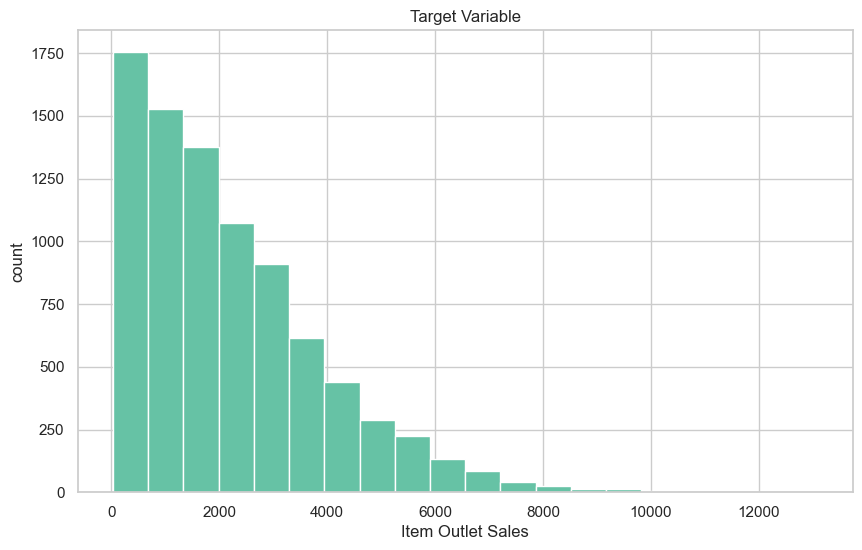

In [20]:
plt.hist(train['Item_Outlet_Sales'], bins = 20)
plt.title('Target Variable')
plt.xlabel('Item Outlet Sales')
plt.ylabel('count')
plt.show()

#### 2.2.2. For Numerical variables

In [22]:
EDAUtils.numeric_summary(data, num_var)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,missing,perc_missing
Item_Weight,11765.0,12.792854,4.652502,4.555,8.710000,12.600000,16.750000,21.350000,0.101309,-1.228094,2439,0.171712
Item_Visibility,14204.0,0.065953,0.051459,0.000,0.027036,0.054021,0.094037,0.328391,1.195175,1.820071,0,0.000000
Item_MRP,14204.0,141.004977,62.086938,31.290,94.012000,142.247000,185.855600,266.888400,0.130728,-0.893856,0,0.000000
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000,1987.000000,1999.000000,2004.000000,2009.000000,-0.396465,-1.205867,0,0.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800,1.177531,1.615877,5681,0.399958


**Insights:**
1. The minimum value of `Item_Visibility` is zero, which is unrealistic since a product available in a store should have some visibility.
2. `Outlet_Establishment_Year` ranges from 1985 to 2009. Instead of using the raw year, calculating the store's age could provide more meaningful insights into its impact on sales.
3. The low count observed for `Item_Weight` and `Item_Outlet_Sales` aligns with the missing value analysis findings.

#### 2.2.3. For Categorical variables

---------- Item_Fat_Content ----------
No. of Unique categories: 5


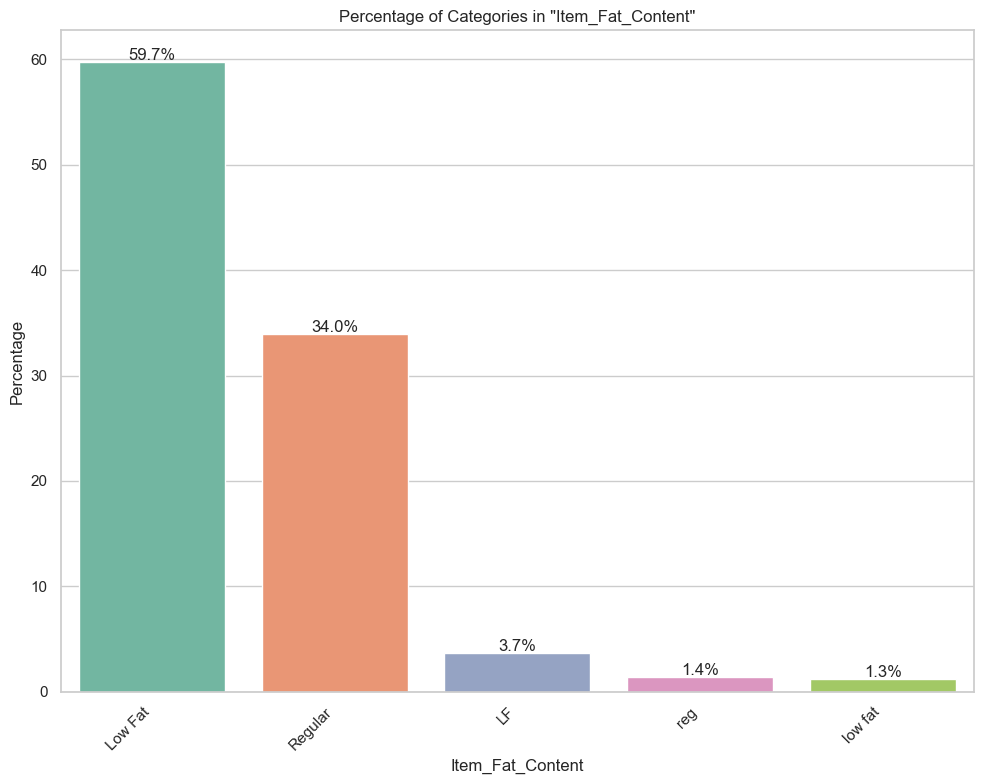

---------- Item_Type ----------
No. of Unique categories: 16


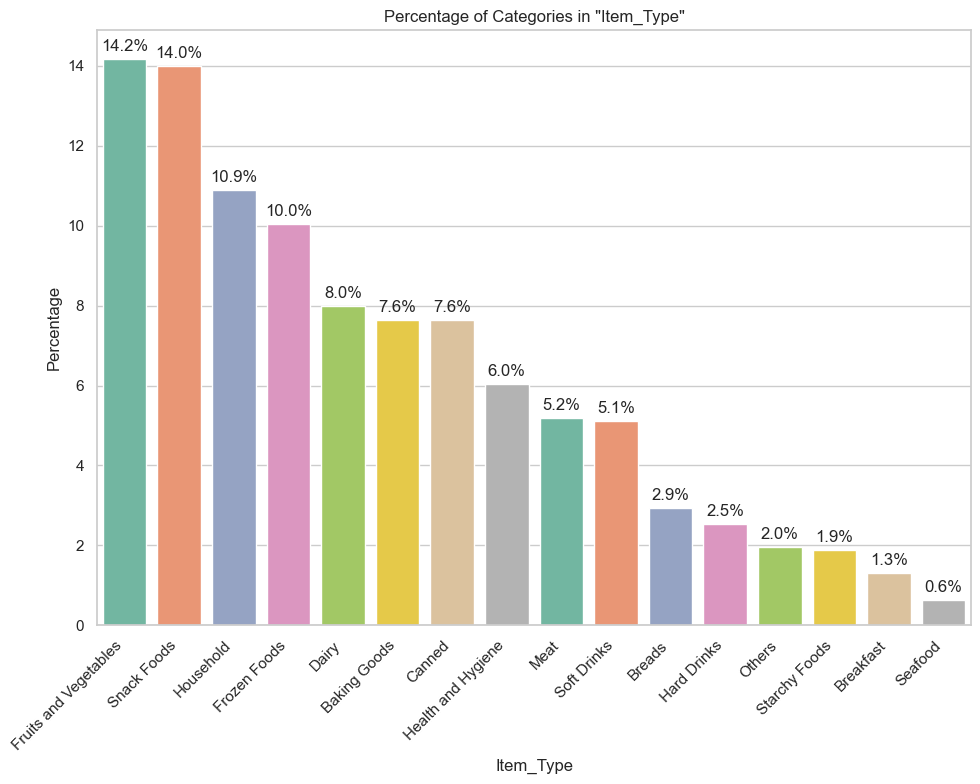

---------- Outlet_Size ----------
No. of Unique categories: 3


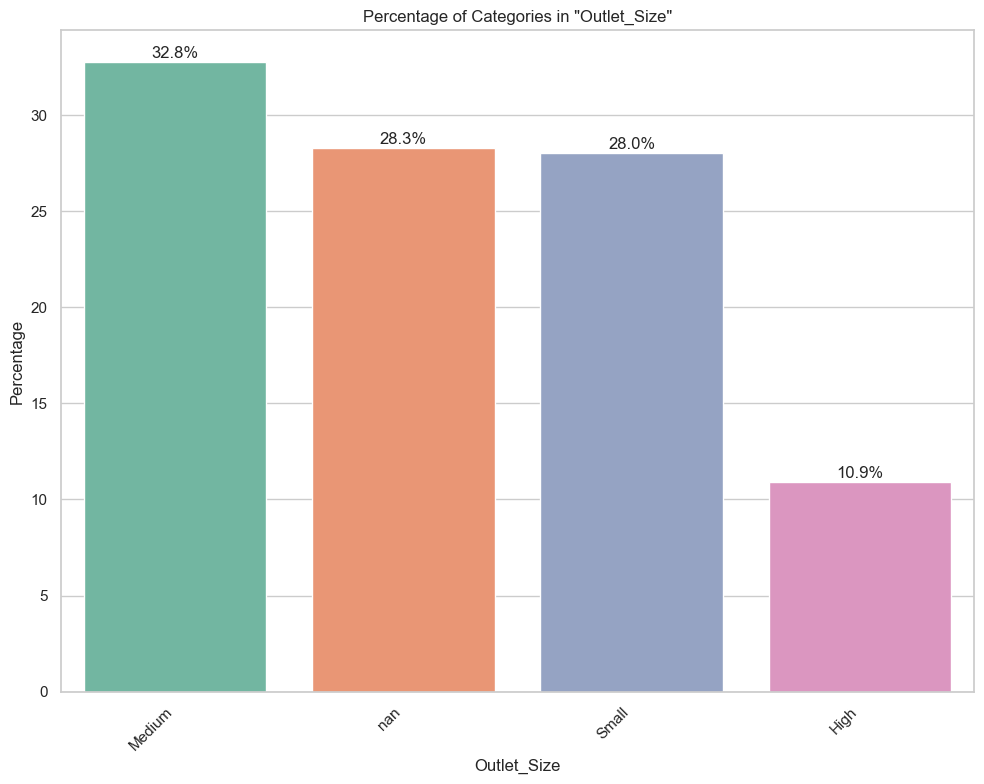

---------- Outlet_Location_Type ----------
No. of Unique categories: 3


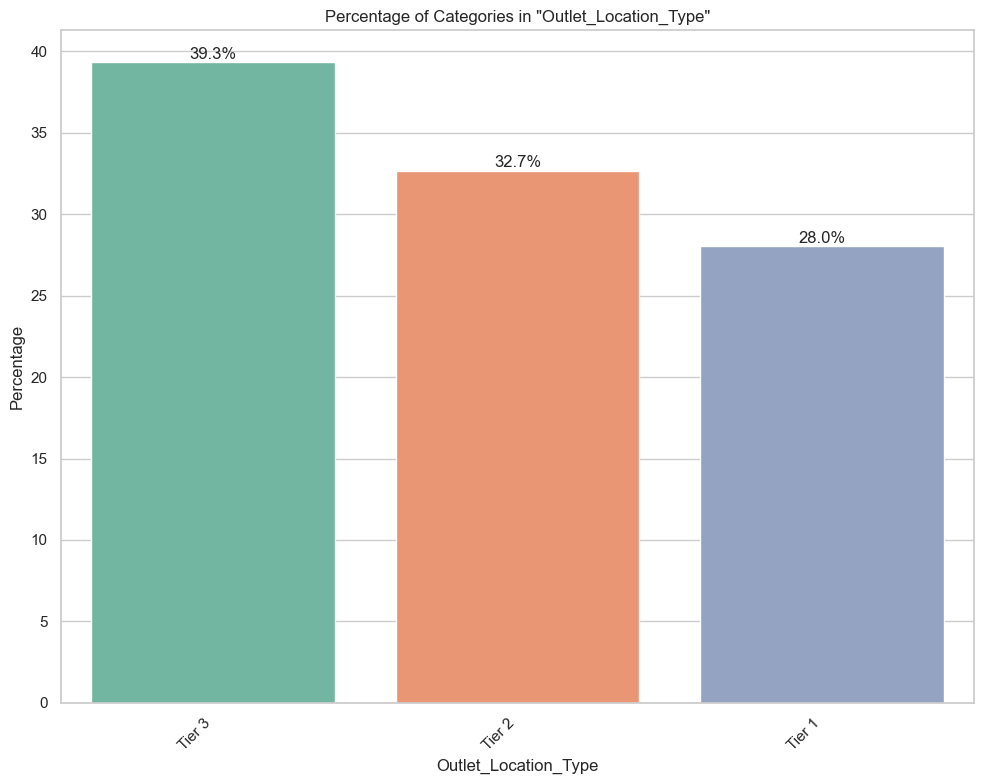

---------- Outlet_Type ----------
No. of Unique categories: 4


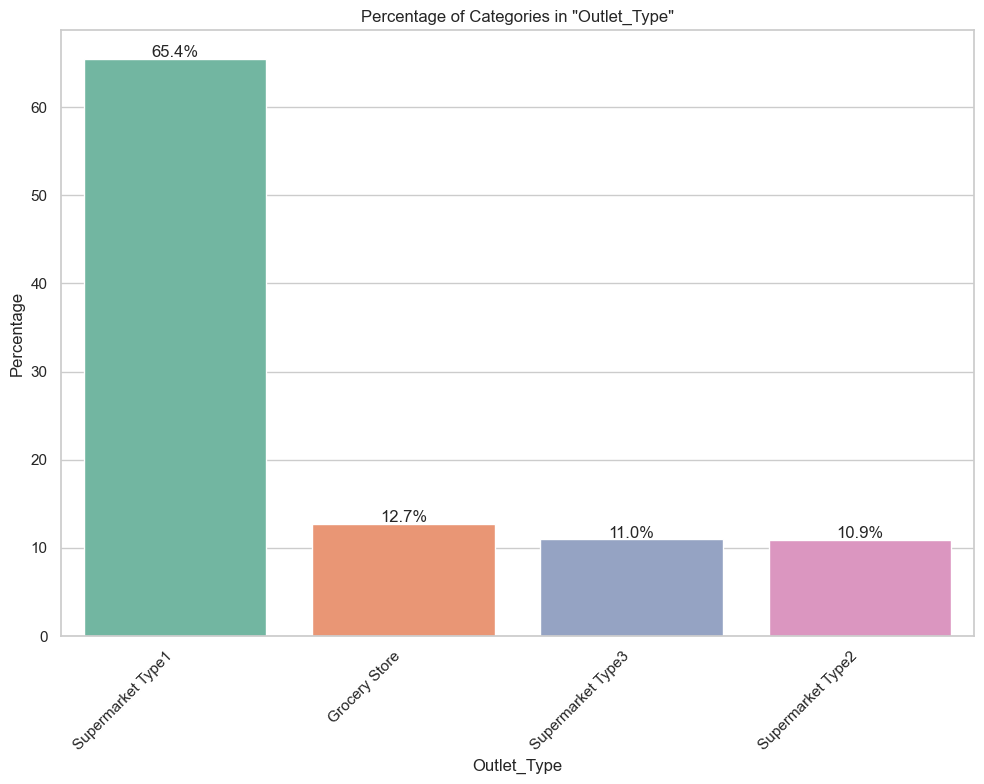

In [25]:
EDAUtils.analyze_categorical_columns(data, cat_var)

**Insights:**
1. `Item_Fat_Content`: The Item_Fat_Content feature shows inconsistent entries, such as variations of 'Low Fat' ('low fat', 'LF') and 'Regular' ('regular'). To maintain uniformity and prevent redundancy during modeling, these categories should be standardized.
2. `Item_Type`: Some item categories have very few observations. Grouping similar low-frequency categories could improve model stability and predictive performance.
3. `Outlet_Type`: 'Supermarket Type2' and 'Supermarket Type3' appear similar (~11% of total categories respectively) and might be candidates for consolidation. However, further analysis is required to validate whether combining them preserves relevant distinctions.

In [27]:
#### for Identifier columns

In [28]:
id_cols

['Item_Identifier', 'Outlet_Identifier', 'source']

In [29]:
for col in id_cols:
    print(f'No of distinct {col}:', data[col].nunique())

No of distinct Item_Identifier: 1559
No of distinct Outlet_Identifier: 10
No of distinct source: 2


In [30]:
data['Item_Identifier'].value_counts()

Item_Identifier
FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: count, Length: 1559, dtype: int64

In [31]:
data['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: count, dtype: int64

### 2.3. Bivariate analysis

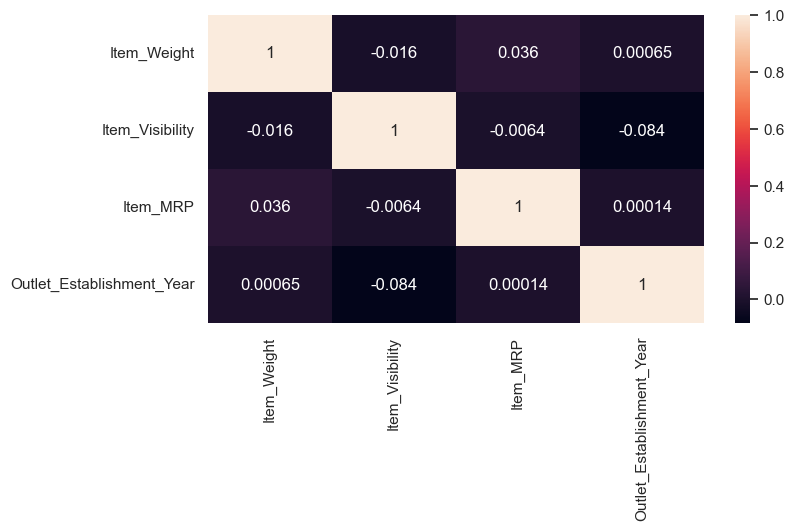

In [33]:
corr = data.drop('Item_Outlet_Sales',axis=1).corr(numeric_only=True)
plt.figure(figsize=(8,4))
sns.heatmap(corr, annot=True)
plt.show()

No correlation exists among predictors

## 3. Preprocessing

### 3.1. Handle missing values

#### 3.1.1. Numerical Variable

We have the Unique product ID i.e., `Item_Identifier` which  would has set of other attribute such as `Item_Weight` and `Item_Type`. So, in our case `Item_Weight` is missing which most probably means each set of `Item_Identifier` will have probably fixed weights. So, imputing missing `Item_Weight` values with the average weight per `Item_Identifier` helps preserve item-specific trends and relationships, reducing bias. It would maintain consistency within each item category.

Imputing missing `Item_Weight` values with the average weight per `Item_Identifier` helps preserve item-specific trends and relationships, reducing bias. This method ensures that missing data is filled with meaningful information, maintaining consistency within each product category. It stabilizes the dataset for modeling, improving predictive performance by allowing the model to learn more effectively without being misled by missing values

In [40]:
data.Item_Identifier.unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [41]:
data[data['Item_Identifier']=='FDA15']['Item_Weight'].describe()

count    8.000000e+00
mean     9.300000e+00
std      1.899005e-15
min      9.300000e+00
25%      9.300000e+00
50%      9.300000e+00
75%      9.300000e+00
max      9.300000e+00
Name: Item_Weight, dtype: float64

In [42]:
data[data['Item_Identifier']=='DRC01']['Item_Weight'].describe()

count    8.000000e+00
mean     5.920000e+00
std      9.495027e-16
min      5.920000e+00
25%      5.920000e+00
50%      5.920000e+00
75%      5.920000e+00
max      5.920000e+00
Name: Item_Weight, dtype: float64

In [43]:
data[data['Item_Identifier']=='NCW05']['Item_Weight'].describe()

count     8.00
mean     20.25
std       0.00
min      20.25
25%      20.25
50%      20.25
75%      20.25
max      20.25
Name: Item_Weight, dtype: float64

Wow! Each `Item_Identifier` has fixed item weights. Now, let's impute the missing values.

In [45]:
# Calculate the average weight per item identifier
item_avg_weight = data.groupby('Item_Identifier')['Item_Weight'].transform('mean')

# Impute missing values in 'Item_Weight' with the calculated average weight
data['Item_Weight'].fillna(item_avg_weight, inplace=True)

In [46]:
data['Item_Weight'].isnull().any()

False

#### 3.1.2. Categorical Variable

In [48]:
data.Outlet_Size.value_counts()

Outlet_Size
Medium    4655
Small     3980
High      1553
Name: count, dtype: int64

In [49]:
data.Outlet_Type.value_counts()

Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: count, dtype: int64

Sinmilarly, for `Outlet_Size` can be imputed by the categories of `Outlet_Type`.

In [51]:
data[data['Outlet_Type']=='Supermarket Type1']['Outlet_Size'].value_counts()

Outlet_Size
Small     3100
High      1553
Medium    1550
Name: count, dtype: int64

In [52]:
data[data['Outlet_Type']=='Grocery Store']['Outlet_Size'].value_counts()

Outlet_Size
Small    880
Name: count, dtype: int64

In [53]:
data[data['Outlet_Type']=='Supermarket Type3']['Outlet_Size'].value_counts()

Outlet_Size
Medium    1559
Name: count, dtype: int64

In [54]:
#Find the most common Outlet_Size for each Outlet_Type
outlet_size_mode = data.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode()[0])

# Fill missing Outlet_Size based on the mode for each Outlet_Type
data['Outlet_Size'] = data.apply(
    lambda row: outlet_size_mode[row['Outlet_Type']] if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'],
    axis=1
)

In [55]:
data['Outlet_Size'].isnull().any()

False

## 4. Feature Engineering

### 4.1. Handle Inconsistencies

#### `Item_Fat_Content` inconsistent categories

In [59]:
# Standardize Item_Fat_Content
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF':'Low Fat',
    'low fat':'Low Fat',
    'reg':'Regular'
})

#### `Item_Visibility` = 0. 
As we have seen min value of `Item_Visibility` was 0 which can't be possible. Let's resolve this.

In [61]:
print(f"No of rows with value zero for Item_Visibility : {data[data['Item_Visibility']==0].shape[0]} i.e., {(data[data['Item_Visibility']==0].shape[0]/data.shape[0])*100}%")

No of rows with value zero for Item_Visibility : 879 i.e., 6.188397634469164%


In [62]:
# Calculate the average visibility for each Item_Identifier
item_visibility_avg = data.groupby('Item_Identifier')['Item_Visibility'].transform('mean')

# Replace zero visibility values with the average visibility for that item
data['Item_Visibility'] = data.apply(
    lambda row: item_visibility_avg[row.name] if row['Item_Visibility'] == 0 else row['Item_Visibility'],
    axis=1
)

### 4.2. Handle high cardinality features

> `Item_Identifier` has more than 1500 categories. Needs to find some way to combine or extract any new feature.

In [65]:
data['Item_Identifier'].nunique()

1559

In [66]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [68]:
data['Item_Identifier'].apply(lambda x: x[0:2]).unique()

array(['FD', 'DR', 'NC'], dtype=object)

Seems like first 2 alphabets have limited Item categories and associated numbers with each of those categories would be probably are the several items associated with it.  It has just 3 categories, which could be use as a feature instead of going with several categories of `Item_Type`.

In [70]:
data.Item_Type.value_counts()

Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64

In [71]:
data['Item_Type_Extracted'] = data['Item_Identifier'].apply(lambda x: x[0:2])

In [72]:
data.Item_Type_Extracted.value_counts()

Item_Type_Extracted
FD    10201
NC     2686
DR     1317
Name: count, dtype: int64

Now there are 3 Item_Type categories. By analysing `Item_Type_Extracted` and `Item_Type` seems to be `Item_Type` is the subset extracted item identifier which contains different type of foods, drinks etc. 

So, can we add some new category for `Item_Fat_Content` since there are 2 categories **Low Fat** and **Regular** which shows still some scope of other type of fat contents. For instance Item_Type has category= `Others` which might be not good for consuming which can have completely different meaning for fat content.

In [75]:
data.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64

In [76]:
data.loc[data['Item_Type_Extracted']=="NC",'Item_Fat_Content'] = "bad"

In [77]:
# Create new feature: Item_Type_Combined
#data['Item_Type_Combined'] = train['Item_Type_Extracted'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

### 4.3. New Features

Products that are displayed more are usually sold more. Instead of only comparing visibility directly, it's better to see how a product’s visibility in a specific store compares to its average visibility across all stores. This helps understand if a store is giving more or less focus to a product compared to others. We can use the visibility_avg we created earlier for this.

In [80]:
# Create new feature: Item_Visibility_MeanRatio
data['Item_Visibility_MeanRatio'] = data['Item_Visibility'] / data.groupby('Item_Identifier')['Item_Visibility'].transform('mean')

We have Outlet_Establishment_Year which can give the lifetime of the store. Let's add it.

In [82]:
data['Outlet_Lifetime'] = 2025 - data['Outlet_Establishment_Year']

### 4.4. Dummy variables

In [138]:
cat_var

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [140]:
id_cols

['Item_Identifier', 'Outlet_Identifier', 'source']

In [142]:
new_cat_var = ['Item_Fat_Content',
 'Item_Type_Extracted',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type'] + ['Outlet_Identifier']

In [144]:
# keep it for test set
data['Outlet_Identifier_copy'] = data['Outlet_Identifier']

In [146]:
data = pd.get_dummies(data, columns=new_cat_var, drop_first=True,dtype=int)

In [148]:
data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Outlet_Lifetime,Outlet_Identifier_copy,Item_Fat_Content_Regular,Item_Fat_Content_bad,Item_Type_Extracted_FD,Item_Type_Extracted_NC,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,9.30,0.016047,Dairy,249.8092,1999,3735.1380,train,0.931078,26,OUT049,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,2009,443.4228,train,0.933420,16,OUT018,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,Meat,141.6180,1999,2097.2700,train,0.872790,26,OUT049,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.017834,Fruits and Vegetables,182.0950,1998,732.3800,train,0.818182,27,OUT010,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.009780,Household,53.8614,1987,994.7052,train,0.750000,38,OUT013,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0


In [150]:
data.rename(columns={'Outlet_Identifier_copy':'Outlet_Identifier'},inplace=True)

In [154]:
data.to_csv("data_combined_preprocessed.csv", index=False)

## 5. Modeling

### 5.1. Feature Selection

In [163]:
drop_cols = ['Item_Identifier','Item_Type','Outlet_Establishment_Year','Outlet_Identifier']
target = ['Item_Outlet_Sales']

In [165]:
trainable_cols = [col for col in data.columns if col not in drop_cols + target + ['source']]
len(trainable_cols)
trainable_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Item_Visibility_MeanRatio',
 'Outlet_Lifetime',
 'Item_Fat_Content_Regular',
 'Item_Fat_Content_bad',
 'Item_Type_Extracted_FD',
 'Item_Type_Extracted_NC',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049']

In [167]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [169]:
# Save Item_Identifier and Outlet_Identifier for submission
test_ids = test[['Item_Identifier', 'Outlet_Identifier']]

In [865]:
from sklearn.ensemble import RandomForestRegressor

### 5.2. Train Model

In [171]:
# Drop unneeded columns
# Define X and y
X = train[trainable_cols]
y = train['Item_Outlet_Sales']

In [173]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### RF

In [175]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
rf.fit(X_train, y_train)

y_pred_rf_tr = rf.predict(X_train)
print("Train - Random Forest RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_rf_tr)))

y_pred_rf = rf.predict(X_valid)
print("Validation - Random Forest RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_rf)))


Train - Random Forest RMSE: 1089.3023771975782
Validation - Random Forest RMSE: 1046.3511659665053


#### XGB

In [177]:
# XGBoost
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
xg_reg.fit(X_train, y_train)

y_pred_xgb_tr = xg_reg.predict(X_train)
print("Train - XGBoost RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_xgb_tr)))

y_pred_xgb = xg_reg.predict(X_valid)
print("Validation - XGBoost RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_xgb)))

Train - XGBoost RMSE: 1010.28345766615
Validation - XGBoost RMSE: 1033.365961081925


### 5.3. Hyperparameter tuning

In [194]:
import numpy as np
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#### RF

In [910]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    return -score  # minimize RMSE

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=50)
print("Best RF params:", study_rf.best_params)
print("Best RF RMSE:", study_rf.best_value)

[I 2025-04-29 12:00:45,456] A new study created in memory with name: no-name-bb9b188e-0623-454d-bd54-c01f75b6c658
[I 2025-04-29 12:00:49,934] Trial 0 finished with value: 1097.8628048670912 and parameters: {'n_estimators': 812, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 1097.8628048670912.
[I 2025-04-29 12:00:51,255] Trial 1 finished with value: 1106.0836017376182 and parameters: {'n_estimators': 171, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 1097.8628048670912.
[I 2025-04-29 12:00:55,433] Trial 2 finished with value: 1113.1428286064397 and parameters: {'n_estimators': 573, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 1097.8628048670912.
[I 2025-04-29 12:01:03,308] Trial 3 finished with value: 1115.0797052203693 and parameters: {'n_estimators': 924, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value:

Best RF params: {'n_estimators': 880, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best RF RMSE: 1090.9208043211245


In [918]:
rf_best_params = study_rf.best_params
rf_best_params

{'n_estimators': 880,
 'max_depth': 7,
 'min_samples_split': 4,
 'min_samples_leaf': 2}

In [922]:
best_model_rf = RandomForestRegressor(**rf_best_params)
best_model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=880)

In [228]:
def evaluation(model, predictors_train, predictors_val, actual_target_train, actual_target_val):

    predictions_train = rf.predict(predictors_train)
    print("Train - Random Forest RMSE:", np.sqrt(mean_squared_error(actual_target_train, predictions_train)))
    
    predictions_val = rf.predict(predictors_val)
    print("Validation - Random Forest RMSE:", np.sqrt(mean_squared_error(actual_target_val, predictions_val)))


    return None

In [934]:
evaluation(best_model_rf, X_train, X_valid, y_train, y_valid)

Train - Random Forest RMSE: 1100.6896603287205
Validation - Random Forest RMSE: 1028.1025158086488


In [ ]:
y_pred_rf_tr = rf.predict(X_train)
print("Train - Random Forest RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_rf_tr)))

y_pred_rf = rf.predict(X_valid)
print("Validation - Random Forest RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_rf)))


#### XGB

In [212]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1)
    }

    model = XGBRegressor(
        **params,
        objective="reg:squarederror",
        random_state=42
    )

    score = cross_val_score(model, X, y, cv=15, scoring="neg_root_mean_squared_error").mean()
    return -score  # minimize RMSE

In [214]:
study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50)
print("Best XGB params:", study_xgb.best_params)
print("Best XGB RMSE:", study_xgb.best_value)

[I 2025-04-29 13:26:54,218] A new study created in memory with name: xgboost_tuning
[I 2025-04-29 13:27:11,928] Trial 0 finished with value: 1124.4537775911356 and parameters: {'n_estimators': 935, 'max_depth': 10, 'learning_rate': 0.007755384548326918, 'subsample': 0.9212440715149489, 'colsample_bytree': 0.5872416920173859, 'gamma': 3.051910558298647, 'reg_alpha': 0.7230562773633443, 'reg_lambda': 0.1755930079533211}. Best is trial 0 with value: 1124.4537775911356.
[I 2025-04-29 13:27:14,450] Trial 1 finished with value: 1147.6116831220547 and parameters: {'n_estimators': 468, 'max_depth': 4, 'learning_rate': 0.13061389771417076, 'subsample': 0.8769783944106092, 'colsample_bytree': 0.8643600737049566, 'gamma': 3.400765494087801, 'reg_alpha': 0.38732426954531907, 'reg_lambda': 0.5405033481050977}. Best is trial 0 with value: 1124.4537775911356.
[I 2025-04-29 13:27:21,119] Trial 2 finished with value: 1178.8776246800303 and parameters: {'n_estimators': 821, 'max_depth': 7, 'learning_rat

Best XGB params: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.022631048270536653, 'subsample': 0.6695922555752873, 'colsample_bytree': 0.811183901326922, 'gamma': 3.523524573900778, 'reg_alpha': 0.6592808338584413, 'reg_lambda': 0.2769268447620156}
Best XGB RMSE: 1082.0652207673966


In [219]:
xgb_best_params = study_xgb.best_params
xgb_best_params

{'n_estimators': 202,
 'max_depth': 4,
 'learning_rate': 0.022631048270536653,
 'subsample': 0.6695922555752873,
 'colsample_bytree': 0.811183901326922,
 'gamma': 3.523524573900778,
 'reg_alpha': 0.6592808338584413,
 'reg_lambda': 0.2769268447620156}

In [246]:
def shap_explainability(model, data):
    """
    Shap Plots from a trained model.

    Args:
        model: Trained model with feature_importances_ attribute.
        data: Feature DataFrame.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values, data)

    return None

def feature_importance(model, data, model_name="Model"):
    """
    Plots feature importances from a trained model.

    Args:
        model: Trained model with feature_importances_ attribute.
        data: Feature DataFrame.
        model_name: Name of the model for plot title.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:20], y=data.columns[indices][:20])
    plt.title(f'Top Feature Importances - {model_name}')
    plt.tight_layout()
    plt.show()

In [226]:
best_model_xgb = XGBRegressor(**xgb_best_params)
best_model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.811183901326922, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=3.523524573900778, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.022631048270536653,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=202, n_jobs=None,
             num_parallel_tree=None, ...)

In [230]:
evaluation(best_model_xgb, X_train, X_valid, y_train, y_valid)

Train - Random Forest RMSE: 1089.3023771975782
Validation - Random Forest RMSE: 1046.3511659665053


Not overfitting

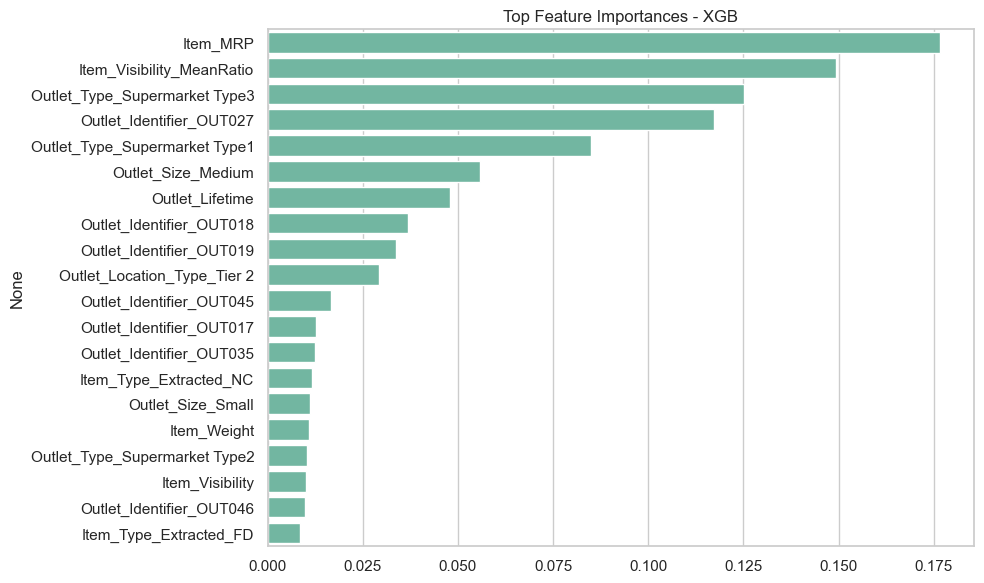

In [240]:
feature_importance(best_model_xgb, X_train, model_name="XGB")

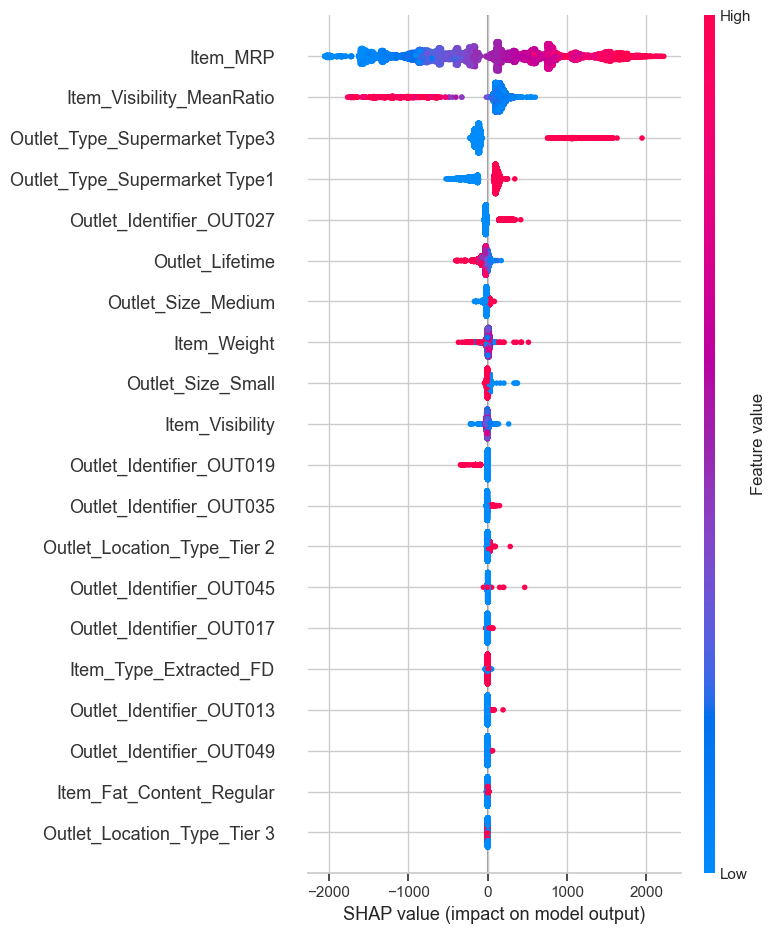

In [248]:
shap_explainability(best_model_xgb, X)

Let's train on the entire dataset.

In [253]:
best_model_xgb = XGBRegressor(**xgb_best_params)
best_model_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.811183901326922, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=3.523524573900778, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.022631048270536653,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=202, n_jobs=None,
             num_parallel_tree=None, ...)

## 6. Scoring

In [939]:
best_model_rf_ov = RandomForestRegressor(**rf_best_params)
best_model_rf_ov.fit(X, y)

RandomForestRegressor(max_depth=7, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=880)

In [964]:
pred = best_model_rf_ov.predict(X)
print("Validation - Random Forest RMSE:", np.sqrt(mean_squared_error(y, pred)))

Validation - Random Forest RMSE: 1034.0627060615232


In [255]:
trainable_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Item_Visibility_MeanRatio',
 'Outlet_Lifetime',
 'Item_Fat_Content_Regular',
 'Item_Fat_Content_bad',
 'Item_Type_Extracted_FD',
 'Item_Type_Extracted_NC',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049']

In [257]:
X_test = test[trainable_cols]

In [947]:
test_preds_rf = best_model_rf_ov.predict(X_test)

In [261]:
test_preds_xgb = best_model_xgb.predict(X_test)

In [265]:
# Prepare Submission
submission = test_ids.copy()
submission['Item_Outlet_Sales'] = test_preds_xgb

In [267]:
submission.to_csv('submission_xgb.csv', index=False)

In [270]:
submission.Item_Outlet_Sales.describe()

count    5681.000000
mean     2185.289795
std      1286.455933
min      -165.047684
25%      1136.986572
50%      2075.168457
75%      3070.417969
max      6644.360840
Name: Item_Outlet_Sales, dtype: float64

In [273]:
submission[submission['Item_Outlet_Sales']<0].shape

(4, 3)

Some has negative `Item_Outlet_Sales` value lets fix it.

In [276]:
submission['Item_Outlet_Sales'] = submission['Item_Outlet_Sales'].apply(lambda x: max(0,x))

In [278]:
submission.to_csv('submission_xgb_1.csv', index=False)